# PyroSense: Wildfire Prediction with Foundation Models

This notebook demonstrates the full PyroSense pipeline:
1. **Data Loading**: Fire events from Mesogeos datacube
2. **HLS Imagery**: Satellite composites from NASA Earthdata
3. **Multi-Source Features**: Prithvi (1024-dim), Weather (10-dim), AlphaEarth (64-dim)
4. **Stacking Ensemble**: Two-level architecture with source-specific base models

## Architecture

```
┌─────────────────┐    ┌─────────────────┐    ┌─────────────────┐
│  HLS Satellite  │    │  Weather Data   │    │   AlphaEarth    │
│    Imagery      │    │  (Open-Meteo)   │    │ (Earth Engine)  │
└────────┬────────┘    └────────┬────────┘    └────────┬────────┘
         │                      │                      │
         ▼                      ▼                      ▼
┌─────────────────┐    ┌─────────────────┐    ┌─────────────────┐
│    Prithvi      │    │    Weather      │    │   AlphaEarth    │
│   Extractor     │    │   Extractor     │    │   Extractor     │
│  (1024 dims)    │    │   (10 dims)     │    │   (64 dims)     │
└────────┬────────┘    └────────┬────────┘    └────────┬────────┘
         │                      │                      │
         ▼                      ▼                      ▼
┌─────────────────┐    ┌─────────────────┐    ┌─────────────────┐
│  Base Model 1   │    │  Base Model 2   │    │  Base Model 3   │
│  (RandomForest) │    │  (RandomForest) │    │  (RandomForest) │
└────────┬────────┘    └────────┬────────┘    └────────┬────────┘
         │                      │                      │
         └──────────────────────┼──────────────────────┘
                                │
                                ▼
                    ┌─────────────────────┐
                    │    Meta-Learner     │
                    │ (LogisticRegression)│
                    └──────────┬──────────┘
                               │
                               ▼
                    ┌─────────────────────┐
                    │   Fire Prediction   │
                    │   P(fire | event)   │
                    └─────────────────────┘
```

## 1. Setup

In [1]:
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress verbose logging and warnings
from loguru import logger
logger.disable("pyrosense")  # Disable pyrosense logs in notebook
warnings.filterwarnings("ignore", category=RuntimeWarning)  # Suppress sklearn warnings

# PyroSense imports
from pyrosense.data.mesogeos_loader import MesogeosLoader, save_events_csv, load_events_csv
from pyrosense.data.hls_downloader import HLSDownloader
from pyrosense.features.prithvi import PrithviExtractor
from pyrosense.features.weather import WeatherExtractor
from pyrosense.features.store import FeatureStore
from pyrosense.models.stacking import StackingEnsemble, StackingConfig

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

# Paths
DATA_DIR = Path("../data")
MESOGEOS_PATH = DATA_DIR / "mesogeos/mesogeos.zarr"
HLS_DIR = DATA_DIR / "hls"
FEATURE_STORE_DIR = DATA_DIR / "features"
EVENTS_CACHE = DATA_DIR / "fire_events.csv"

print(f"Data directory: {DATA_DIR.resolve()}")

Data directory: /Users/georgepapakonstantinou/Documents/hackathon/data


## 2. Load Fire Events from Mesogeos

Mesogeos is used **only** for fire labels (where/when fires occurred).
The predictive features come from Prithvi, Weather, and AlphaEarth.

In [2]:
# Load or extract fire events
if EVENTS_CACHE.exists():
    all_events = load_events_csv(str(EVENTS_CACHE))
    fire_events = [e for e in all_events if e.burned_area > 0]
    negative_events = [e for e in all_events if e.burned_area == 0]
    print(f"Loaded from cache: {len(fire_events)} fire + {len(negative_events)} no-fire")
else:
    loader = MesogeosLoader(str(MESOGEOS_PATH), region="greece")
    fire_events = loader.extract_fire_events(
        n_samples=100, min_burned_area=0.0,
        start_year=2015, end_year=2021, random_seed=42,
    )
    # Sample negative events from DIFFERENT locations (no spatial leakage)
    negative_events = loader.sample_negative_events_different_locations(
        n_samples=100,
        fire_events=fire_events,
        min_distance_deg=0.1,  # ~10km minimum from any fire
        random_seed=42,
    )
    all_events = fire_events + negative_events
    save_events_csv(all_events, str(EVENTS_CACHE))
    print(f"Extracted: {len(fire_events)} fire + {len(negative_events)} no-fire")

all_events = fire_events + negative_events
print(f"Total events: {len(all_events)}")

# Create labels
labels = {e.event_id: 1.0 if e.burned_area > 0 else 0.0 for e in all_events}
y = np.array([labels[e.event_id] for e in all_events])

Loaded from cache: 100 fire + 100 no-fire
Total events: 200


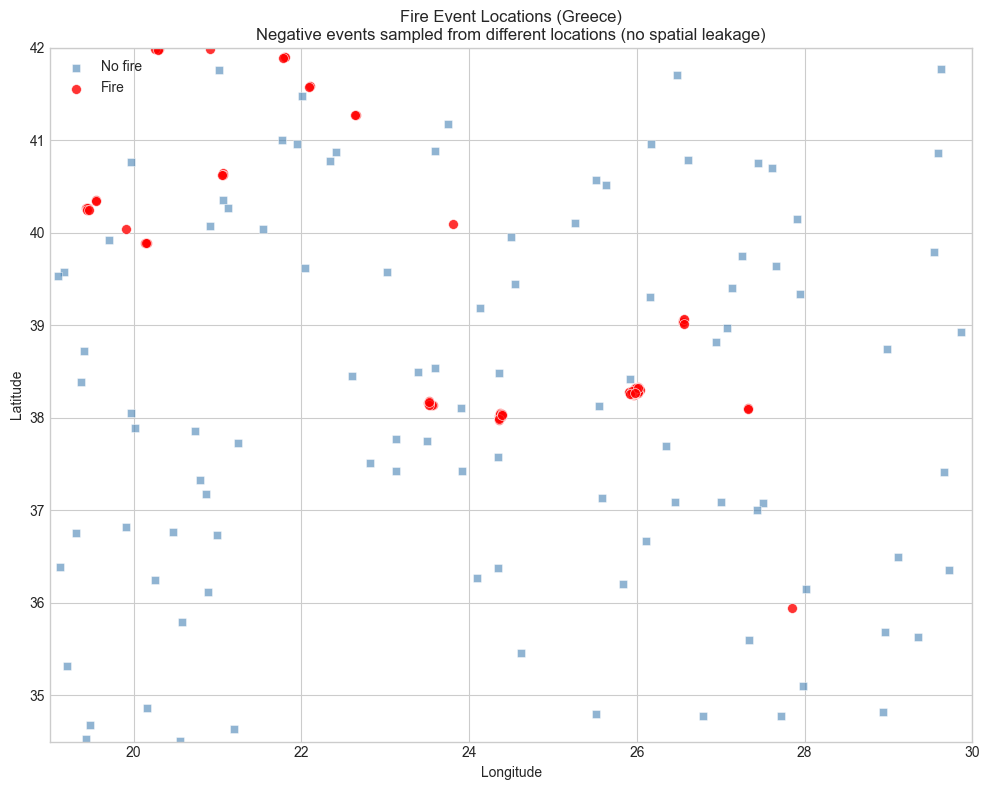

In [3]:
# Visualize fire event locations
fig, ax = plt.subplots(figsize=(10, 8))

fire_lats = [e.latitude for e in fire_events]
fire_lons = [e.longitude for e in fire_events]
neg_lats = [e.latitude for e in negative_events]
neg_lons = [e.longitude for e in negative_events]

# No jitter needed - locations are now different
ax.scatter(neg_lons, neg_lats, c='steelblue', alpha=0.6, s=40, 
           marker='s', label='No fire', edgecolors='white', linewidth=0.5)
ax.scatter(fire_lons, fire_lats, c='red', alpha=0.8, s=50, 
           marker='o', label='Fire', edgecolors='white', linewidth=0.5)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Fire Event Locations (Greece)\nNegative events sampled from different locations (no spatial leakage)')
ax.legend()
ax.set_xlim(19, 30)
ax.set_ylim(34.5, 42)
plt.tight_layout()
plt.show()

## 3. Download HLS Satellite Imagery

For each event, we download a 6-band HLS composite from NASA Earthdata.
The 6 bands (Blue, Green, Red, NIR, SWIR1, SWIR2) are what Prithvi expects.

In [4]:
# Skip downloading - just use what's already on disk
SKIP_HLS_DOWNLOAD = True  # Set to False to download missing images

downloader = HLSDownloader(
    output_dir=str(HLS_DIR),
    days_before=30,
    min_days_before=7,
)

if SKIP_HLS_DOWNLOAD:
    print("Skipping HLS download - using cached composites only")
    composites = downloader.get_available_composites()
    print(f"Found {len(composites)} cached HLS composites")
    
    # Count how many events have imagery
    fire_with_hls = sum(1 for e in fire_events if e.event_id in composites)
    nofire_with_hls = sum(1 for e in negative_events if e.event_id in composites)
    print(f"  Fire events with HLS: {fire_with_hls}/{len(fire_events)}")
    print(f"  No-fire events with HLS: {nofire_with_hls}/{len(negative_events)}")
else:
    print("Downloading HLS imagery (7-30 days BEFORE each event)")
    print("=" * 60)
    successes, failures = downloader.download_for_events(all_events)
    print(f"\nDownload complete: {len(successes)}/{len(all_events)} succeeded")
    composites = downloader.get_available_composites()

print(f"\nTotal available composites: {len(composites)}")

Skipping HLS download - using cached composites only
Found 170 cached HLS composites
  Fire events with HLS: 98/100
  No-fire events with HLS: 72/100

Total available composites: 170


## 4. Feature Extraction with FeatureStore

We extract features from multiple sources and store them using the project's FeatureStore.

In [5]:
# Initialize the feature store
store = FeatureStore(str(FEATURE_STORE_DIR))

print(f"Feature store: {FEATURE_STORE_DIR}")
print(f"Existing sources: {store.list_sources()}")

Feature store: ../data/features
Existing sources: ['prithvi', 'weather', 'alphaearth']


### 4.1 Prithvi Features (1024-dim)

Extract features from frozen Prithvi-EO-2.0-300M encoder.

In [6]:
if store.exists("prithvi"):
    prithvi_df = store.load("prithvi")
    print(f"Loaded Prithvi features from store: {prithvi_df.shape}")
else:
    print("Extracting Prithvi features...")
    prithvi_extractor = PrithviExtractor(model_name="Prithvi-EO-2.0-300M", device="auto")
    print(f"Device: {prithvi_extractor.device}")
    
    # Get available composites
    composites = downloader.get_available_composites()
    print(f"Found {len(composites)} HLS composites")
    
    # Build image paths for events with available composites
    image_paths = []
    events_with_images = []
    for event in all_events:
        composite = composites.get(event.event_id)
        if composite and composite.exists():
            image_paths.append(composite)
            events_with_images.append(event)
    
    print(f"Events with HLS imagery: {len(events_with_images)}/{len(all_events)}")
    
    # Extract features (returns DataFrame with prithvi_ prefix already)
    prithvi_df = prithvi_extractor.extract_batch(events_with_images, image_paths=image_paths)
    
    # Save to store
    store.save("prithvi", prithvi_df)
    print(f"Extracted and saved: {prithvi_df.shape}")

print(f"Prithvi features: {prithvi_df.shape[1]} dimensions")

Loaded Prithvi features from store: (170, 1024)
Prithvi features: 1024 dimensions


### 4.2 Weather Features (Configurable)

Extract weather from Open-Meteo API with two options:
- **Aggregated (10-dim)**: min/max/mean over N days (default, efficient)
- **Daily (N×9 dim)**: All 9 variables for each day (captures temporal patterns)

**Toggle `USE_DAILY_WEATHER` below to switch modes.**

In [7]:
# ============================================================
# WEATHER FEATURE CONFIGURATION
# ============================================================
USE_DAILY_WEATHER = True  # Set to False for aggregated features (10-dim)
WEATHER_DAYS_BEFORE = 7   # Number of days to look back

cache_key = "weather"

if USE_DAILY_WEATHER:
    expected_dims = WEATHER_DAYS_BEFORE * 9
    print(f"Weather Mode: DAILY ({expected_dims}-dim, {WEATHER_DAYS_BEFORE} days)")
else:
    expected_dims = 10
    print(f"Weather Mode: AGGREGATED ({expected_dims}-dim, {WEATHER_DAYS_BEFORE} days)")

# Auto-delete cache if dimensions don't match (switching modes)
if store.exists(cache_key):
    cached_df = store.load(cache_key)
    if cached_df.shape[1] != expected_dims:
        cache_file = FEATURE_STORE_DIR / cache_key / "v1.parquet"
        if cache_file.exists():
            cache_file.unlink()
        else:
            import shutil
            shutil.rmtree(FEATURE_STORE_DIR / cache_key, ignore_errors=True)

# Extract or load features
if store.exists(cache_key):
    weather_df = store.load(cache_key)
    print(f"Loaded from cache: {weather_df.shape}")
else:
    print(f"Extracting features...")
    
    if USE_DAILY_WEATHER:
        from pyrosense.features.weather import DailyWeatherExtractor
        weather_extractor = DailyWeatherExtractor(days_before=WEATHER_DAYS_BEFORE)
    else:
        weather_extractor = WeatherExtractor(days_before=WEATHER_DAYS_BEFORE)
    
    weather_df = weather_extractor.extract_batch(all_events)
    store.save(cache_key, weather_df)
    print(f"Extracted and saved: {weather_df.shape}")

print(f"Weather features: {weather_df.shape[1]} dimensions")
if USE_DAILY_WEATHER:
    print(f"  First: {list(weather_df.columns[:3])}")
    print(f"  Last:  {list(weather_df.columns[-3:])}")
else:
    print(f"  Features: {list(weather_df.columns)}")

Weather Mode: DAILY (63-dim, 7 days)
Loaded from cache: (200, 63)
Weather features: 63 dimensions
  First: ['weather_d1_temperature_max', 'weather_d1_temperature_min', 'weather_d1_temperature_mean']
  Last:  ['weather_d7_wind_speed_max', 'weather_d7_wind_speed_mean', 'weather_d7_precipitation_sum']


### 4.3 AlphaEarth Features (64-dim) - Optional

Extract land surface embeddings from Google Earth Engine.

**Note:** Requires Earth Engine authentication. Skip if not configured.

In [8]:
import os

# AlphaEarth - requires Earth Engine authentication
USE_ALPHAEARTH = True

# Set your GCP project ID here or via environment variable GOOGLE_CLOUD_PROJECT
GCP_PROJECT = os.environ.get("GOOGLE_CLOUD_PROJECT", None) or "pyrosense"

if USE_ALPHAEARTH:
    if not GCP_PROJECT:
        print("AlphaEarth requires a GCP project ID.")
        print("   Set via: export GOOGLE_CLOUD_PROJECT=your-project-id")
        print("   Skipping AlphaEarth features...")
        alphaearth_df = None
    else:
        from pyrosense.features.alphaearth import AlphaEarthExtractor
        
        if store.exists("alphaearth"):
            alphaearth_df = store.load("alphaearth")
            print(f"Loaded AlphaEarth features from store: {alphaearth_df.shape}")
        else:
            print(f"Extracting AlphaEarth features (project: {GCP_PROJECT})...")
            alphaearth_extractor = AlphaEarthExtractor(
                cache_dir=str(DATA_DIR / "alphaearth"),
                project=GCP_PROJECT
            )
            
            # extract_batch returns DataFrame with alphaearth_ prefix already
            alphaearth_df = alphaearth_extractor.extract_batch(all_events)
            
            store.save("alphaearth", alphaearth_df)
            print(f"Extracted and saved: {alphaearth_df.shape}")
        
        print(f"AlphaEarth features: {alphaearth_df.shape[1]} dimensions")
else:
    print("AlphaEarth disabled.")
    alphaearth_df = None

Loaded AlphaEarth features from store: (200, 64)
AlphaEarth features: 64 dimensions


### 4.4 Combine Features

Merge all feature sources into a single DataFrame.

In [9]:
# Combine available features
sources = ["prithvi", "weather"]
if alphaearth_df is not None:
    sources.append("alphaearth")

X_combined = store.get_combined(sources)

# Get events that have all features (primarily limited by Prithvi/HLS availability)
available_events = [e for e in all_events if e.event_id in X_combined.index]
print(f"Events with all features: {len(available_events)}/{len(all_events)}")

# Align with available events
event_ids = [e.event_id for e in available_events]
X_combined = X_combined.reindex(event_ids)

# Update labels for available events
y_aligned = np.array([labels[eid] for eid in X_combined.index])

print(f"Combined features shape: {X_combined.shape}")
print(f"Sources: {sources}")
print(f"\nFeature breakdown:")
for source in sources:
    cols = [c for c in X_combined.columns if c.startswith(f"{source}_")]
    print(f"  {source}: {len(cols)} dimensions")
    
print(f"\nClass balance: {y_aligned.mean():.1%} fire, {1-y_aligned.mean():.1%} no-fire")

Events with all features: 170/200
Combined features shape: (170, 1151)
Sources: ['prithvi', 'weather', 'alphaearth']

Feature breakdown:
  prithvi: 1024 dimensions
  weather: 63 dimensions
  alphaearth: 64 dimensions

Class balance: 57.6% fire, 42.4% no-fire


## 5. Train/Test Split

Split the data into training and test sets for model evaluation.

In [10]:
from sklearn.model_selection import train_test_split

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_aligned, test_size=0.2, random_state=42, stratify=y_aligned
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")
print(f"Class balance (train): {y_train.mean():.1%} fire")

Train: 136 samples
Test:  34 samples
Class balance (train): 57.4% fire


## 6. Hyperparameter Optimization

Optimize classifier parameters for all 3 feature sources using GridSearchCV.

**Configuration**: Set `RUN_HYPERPARAMETER_TUNING = True` to optimize base models, or `False` to use default RandomForest models.

The optimization tests multiple classifier types:
- **Random Forest (RF)**: Best for high-dimensional data (Prithvi)
- **XGBoost (XGB)**: Powerful gradient boosting for all feature types
- **Gradient Boosting (GB)**: Alternative boosting method

Each source gets tuned separately with source-specific parameter grids.

In [11]:
# ============================================================
# HYPERPARAMETER TUNING CONFIGURATION
# ============================================================
RUN_HYPERPARAMETER_TUNING = True  # Set to False to skip optimization

if RUN_HYPERPARAMETER_TUNING:
    print("="*60)
    print("Hyperparameter tuning ENABLED")
    print("Will optimize RF, XGBoost, and GradientBoosting for each source")
    print("This may take 5-10 minutes...")
    print("="*60)
else:
    print("="*60)
    print("Hyperparameter tuning DISABLED")
    print("Will use default RandomForest models")
    print("="*60)

Hyperparameter tuning ENABLED
Will optimize RF, XGBoost, and GradientBoosting for each source
This may take 5-10 minutes...


In [12]:
# Conditional hyperparameter tuning
if RUN_HYPERPARAMETER_TUNING:
    from pyrosense.models.optimization import optimize_base_models
    
    # Optimize base models for each feature source
    best_base_models = optimize_base_models(
        X_train=X_train,
        y_train=y_train,
        sources=sources,
        verbose=True
    )
else:
    # Skip tuning
    best_base_models = {}
    print("Skipping hyperparameter tuning - will use default models")

Starting Hyperparameter Optimization

Tuning PRITHVI - RF...
  -> Best CV AUC: 0.9111
  -> Best Params: {'max_depth': 10, 'max_features': 0.1, 'min_samples_leaf': 1, 'n_estimators': 100}

Tuning WEATHER - RF...
  -> Best CV AUC: 0.9765
  -> Best Params: {'max_depth': 5, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 150}

Tuning WEATHER - XGB...
  -> Best CV AUC: 0.9752
  -> Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}

Tuning WEATHER - GB...
  -> Best CV AUC: 0.9810
  -> Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Tuning ALPHAEARTH - RF...
  -> Best CV AUC: 0.7760
  -> Best Params: {'max_depth': 10, 'max_features': 0.3, 'min_samples_leaf': 2, 'n_estimators': 200}

Tuning ALPHAEARTH - XGB...
  -> Best CV AUC: 0.7626
  -> Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Tuning ALPHAEARTH - GB...
  -> Best CV AUC: 0.7640
  -> Best Param


OPTIMIZED MODELS - Test Set Performance
    Source Model  Test AUC  Accuracy
   Weather    GB  0.982143  0.852941
   Prithvi    RF  0.962500  0.882353
   Weather    RF  0.953571  0.852941
   Weather   XGB  0.939286  0.882353
Alphaearth    GB  0.885714  0.823529
Alphaearth    RF  0.875000  0.852941
Alphaearth   XGB  0.871429  0.882353


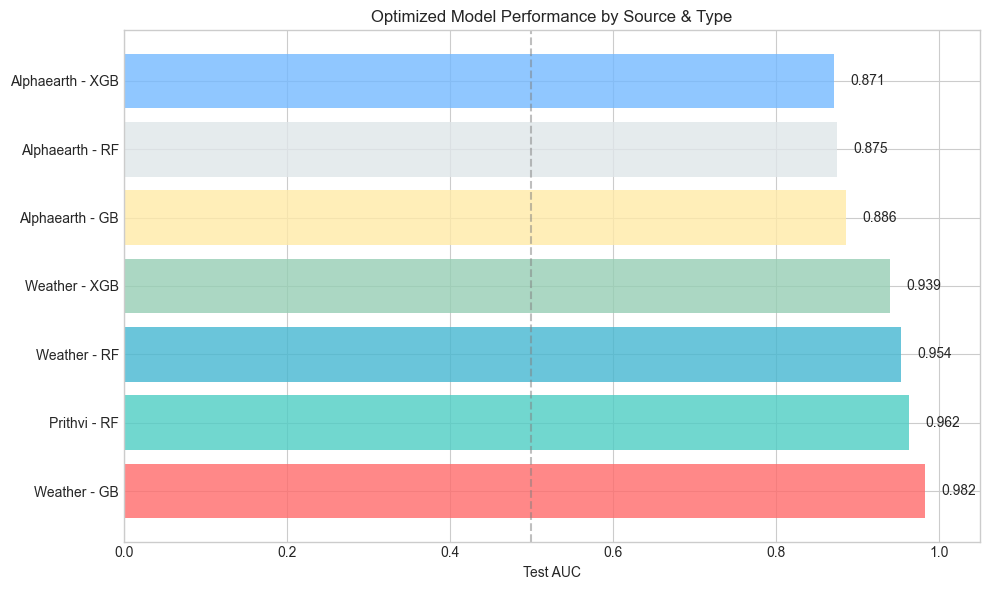

In [13]:
# Compare optimized models on test set (conditional)
if RUN_HYPERPARAMETER_TUNING and best_base_models:
    from sklearn.metrics import roc_auc_score, accuracy_score
    from sklearn.preprocessing import StandardScaler
    import numpy as np

    optimization_results = []

    for model_key, model in best_base_models.items():
        source, model_type = model_key.split('_')
        
        # Get test data for this source
        cols = [c for c in X_test.columns if c.startswith(f"{source}_")]
        X_source_test = X_test[cols].values
        
        # Preprocess (same as training)
        scaler = StandardScaler()
        # Fit on training data
        cols_train = [c for c in X_train.columns if c.startswith(f"{source}_")]
        X_source_train = X_train[cols_train].values
        X_source_scaled_train = scaler.fit_transform(X_source_train)
        
        # Transform test data
        X_source_scaled_test = scaler.transform(X_source_test)
        X_source_clean_test = np.nan_to_num(X_source_scaled_test, nan=0.0)
        
        # Predict
        y_prob_opt = model.predict_proba(X_source_clean_test)[:, 1]
        y_pred_opt = model.predict(X_source_clean_test)
        
        # Calculate metrics
        auc = roc_auc_score(y_test, y_prob_opt)
        acc = accuracy_score(y_test, y_pred_opt)
        
        optimization_results.append({
            'Source': source.capitalize(),
            'Model': model_type.upper(),
            'Test AUC': auc,
            'Accuracy': acc
        })

    # Display results
    opt_results_df = pd.DataFrame(optimization_results).sort_values('Test AUC', ascending=False)

    print("\n" + "=" * 60)
    print("OPTIMIZED MODELS - Test Set Performance")
    print("=" * 60)
    print(opt_results_df.to_string(index=False))
    print("=" * 60)

    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    opt_results_df['Label'] = opt_results_df['Source'] + ' - ' + opt_results_df['Model']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DFE6E9', '#74B9FF']
    bars = ax.barh(opt_results_df['Label'], opt_results_df['Test AUC'], 
                   color=colors[:len(opt_results_df)], alpha=0.8)

    ax.set_xlabel('Test AUC')
    ax.set_title('Optimized Model Performance by Source & Type')
    ax.set_xlim(0, 1.05)
    ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

    # Add value labels
    for bar, val in zip(bars, opt_results_df['Test AUC']):
        ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
                va='center', fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("Hyperparameter tuning was skipped - no optimization results to display")
    optimization_results = []
    opt_results_df = pd.DataFrame()

In [14]:
# Select best model for each source (with fallback to defaults)
best_models_map = {}

if RUN_HYPERPARAMETER_TUNING and best_base_models:
    # Use optimization results
    print("Selecting best optimized model for each source...")

    for source in sources:
        # Filter results for this source
        source_results = [r for r in optimization_results
                         if r['Source'].lower() == source]

        if source_results:
            # Sort by test AUC and pick the best
            best = max(source_results, key=lambda x: x['Test AUC'])
            model_type = best['Model'].lower()
            model_key = f"{source}_{model_type}"

            best_models_map[source] = model_key
            print(f"  {source:12s}: {model_key:20s} (AUC: {best['Test AUC']:.4f})")
else:
    # Fallback to defaults
    print("Using default RandomForest for all sources (no optimization)")
    best_models_map = {source: "default_rf" for source in sources}

print(f"\nModel selection: {best_models_map}")

Selecting best optimized model for each source...
  prithvi     : prithvi_rf           (AUC: 0.9625)
  weather     : weather_gb           (AUC: 0.9821)
  alphaearth  : alphaearth_gb        (AUC: 0.8857)

Model selection: {'prithvi': 'prithvi_rf', 'weather': 'weather_gb', 'alphaearth': 'alphaearth_gb'}


In [15]:
# Save optimized models to disk (conditional)
if RUN_HYPERPARAMETER_TUNING and best_base_models:
    import joblib

    MODELS_DIR = DATA_DIR / "optimized_models"
    MODELS_DIR.mkdir(exist_ok=True)

    print("Saving optimized models to disk...")
    print("=" * 60)

    for model_key, model in best_base_models.items():
        model_path = MODELS_DIR / f"{model_key}.pkl"
        joblib.dump(model, model_path)
        
        # Get model size
        size_mb = model_path.stat().st_size / (1024 * 1024)
        print(f"  ✓ Saved: {model_key:20s} → {model_path.name:25s} ({size_mb:.2f} MB)")

    print("=" * 60)
    print(f"\nAll {len(best_base_models)} models saved to: {MODELS_DIR}")
    print(f"\nTo load a model later:")
    print(f"  model = joblib.load('{MODELS_DIR}/weather_xgb.pkl')")
else:
    print("No optimized models to save (tuning was skipped)")

Saving optimized models to disk...
  ✓ Saved: prithvi_rf           → prithvi_rf.pkl            (0.17 MB)
  ✓ Saved: weather_rf           → weather_rf.pkl            (0.21 MB)
  ✓ Saved: weather_xgb          → weather_xgb.pkl           (0.25 MB)
  ✓ Saved: weather_gb           → weather_gb.pkl            (0.25 MB)
  ✓ Saved: alphaearth_rf        → alphaearth_rf.pkl         (0.22 MB)
  ✓ Saved: alphaearth_xgb       → alphaearth_xgb.pkl        (0.17 MB)
  ✓ Saved: alphaearth_gb        → alphaearth_gb.pkl         (0.34 MB)

All 7 models saved to: ../data/optimized_models

To load a model later:
  model = joblib.load('../data/optimized_models/weather_xgb.pkl')


## 7. Stacking Ensemble

The stacking ensemble uses:
- **Level 1 (Base models)**: Optimized models (if tuning enabled) or default RandomForest per source
- **Level 2 (Meta-learner)**: LogisticRegression on base model predictions

This allows each source to be modeled independently, then combined optimally.

In [16]:
# Build stacking ensemble with best available models
import joblib
from pyrosense.models.stacking import StackingConfig, FeatureGroup
from sklearn.linear_model import LogisticRegression

print("Building stacking ensemble...")

if RUN_HYPERPARAMETER_TUNING and best_base_models:
    # Use optimized models from memory (already trained)
    print("Using OPTIMIZED base models:")
    
    # Create config with optimized base models
    config = StackingConfig(
        feature_groups=[
            FeatureGroup(
                name=source,
                column_prefix=f"{source}_",
                base_model=best_base_models[best_models_map[source]]
            )
            for source in sources
        ],
        meta_model=LogisticRegression(max_iter=1000, random_state=42),
        cv_folds=5,
        use_probabilities=True,
        scale_features=True
    )
    
    for source in sources:
        model_key = best_models_map[source]
        print(f"  {source:12s}: {model_key}")
else:
    # Fall back to default models
    print("Using DEFAULT RandomForest base models:")
    config = StackingConfig.simple(sources=sources)
    
    for source in sources:
        print(f"  {source:12s}: RandomForest(default)")

# Train ensemble
ensemble = StackingEnsemble(config)
ensemble.fit(X_train, y_train)

print("\n" + "="*60)
print("Stacking Ensemble Summary")
print("="*60)
print(ensemble.summary())

Building stacking ensemble...
Using OPTIMIZED base models:
  prithvi     : prithvi_rf
  weather     : weather_gb
  alphaearth  : alphaearth_gb

Stacking Ensemble Summary
{'n_feature_groups': 3, 'feature_groups': ['prithvi', 'weather', 'alphaearth'], 'features_per_group': {'prithvi': 1024, 'weather': 63, 'alphaearth': 64}, 'meta_model': 'LogisticRegression', 'source_weights': {'prithvi': 2.5076889270892826, 'weather': 2.4870784467251745, 'alphaearth': 1.2319859988653732}, 'config': {'cv_folds': 5, 'use_probabilities': True, 'scale_features': True}}


### 7.1 Evaluation

In [17]:
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, 
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# Predictions
y_prob = ensemble.predict_proba(X_test)[:, 1]
y_pred = ensemble.predict(X_test)

# Metrics
print("=" * 50)
print("STACKING ENSEMBLE - Test Set Metrics")
print("=" * 50)
print(f"  AUC:       {roc_auc_score(y_test, y_prob):.4f}")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"  F1:        {f1_score(y_test, y_pred, zero_division=0):.4f}")

STACKING ENSEMBLE - Test Set Metrics
  AUC:       0.9857
  Accuracy:  0.8824
  Precision: 0.8333
  Recall:    1.0000
  F1:        0.9091


In [18]:
# Source contribution weights
weights = ensemble.source_weights()

print("\nSource Contribution Weights:")
for source, weight in sorted(weights.items(), key=lambda x: -x[1]):
    bar = "█" * int(weight * 40)
    print(f"  {source:12s}: {weight:.3f} {bar}")


Source Contribution Weights:
  prithvi     : 2.508 ████████████████████████████████████████████████████████████████████████████████████████████████████
  weather     : 2.487 ███████████████████████████████████████████████████████████████████████████████████████████████████
  alphaearth  : 1.232 █████████████████████████████████████████████████


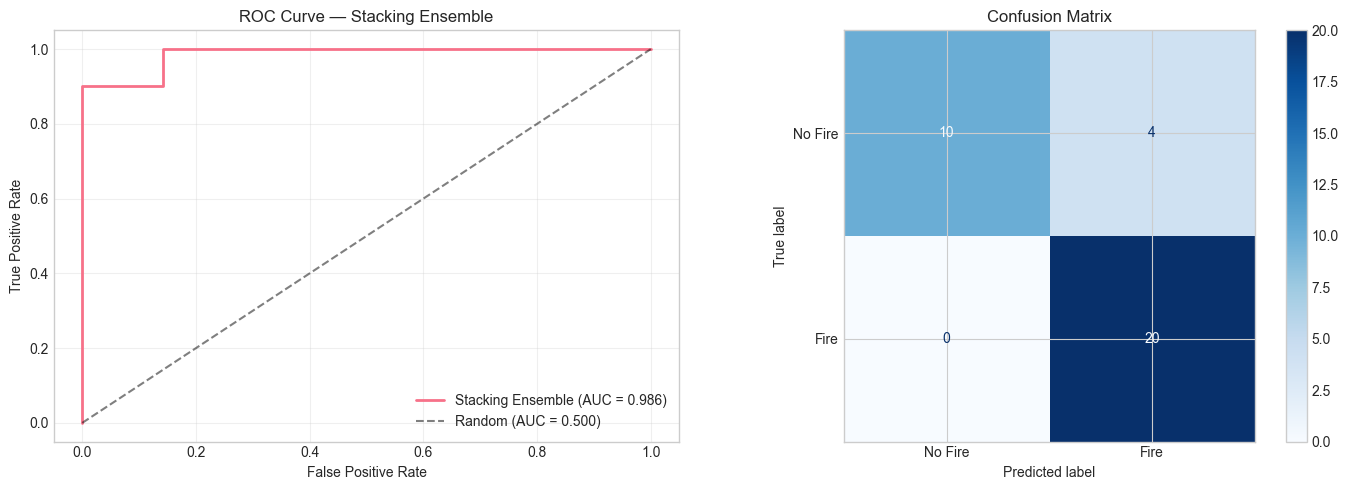

In [19]:
# ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC
ax = axes[0]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_val = roc_auc_score(y_test, y_prob)

ax.plot(fpr, tpr, linewidth=2, label=f'Stacking Ensemble (AUC = {auc_val:.3f})')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC = 0.500)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve — Stacking Ensemble')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# Confusion Matrix
ax = axes[1]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Fire', 'Fire'])
disp.plot(ax=ax, cmap='Blues')
ax.set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

### 7.2 Cross-Validation

In [20]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score

# Re-train on full data for CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a fresh ensemble for CV
cv_ensemble = StackingEnsemble(config)

# Use custom scorer to ensure predict_proba is used correctly
def auc_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_prob)

cv_scores = cross_val_score(
    cv_ensemble, X_combined, y_aligned, 
    cv=cv, scoring=auc_scorer
)

print(f"5-Fold CV AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"  Per fold: {[f'{s:.3f}' for s in cv_scores]}")

5-Fold CV AUC: 0.9788 ± 0.0168
  Per fold: ['0.996', '1.000', '0.975', '0.965', '0.958']


### 7.3 Comparison: Stacking vs Single Source

Compare the stacking ensemble against using only one feature source.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

results = []

# Mapping of source to best model based on hyperparameter tuning results
best_source_models = {
    'prithvi': 'prithvi_rf',      # Only option, CV AUC: 0.9111
    'weather': 'weather_gb',      # Best of 3, CV AUC: 0.9740
    'alphaearth': 'alphaearth_rf' # Best of 3, CV AUC: 0.7760
}

# Test each source with its best optimized model
for source in sources:
    model_key = best_source_models.get(source)

    if model_key and model_key in best_base_models:
        # Get the optimized model
        model = best_base_models[model_key]
        model_type = model_key.split('_')[1].upper()

        # Get columns for this source
        cols = [c for c in X_combined.columns if c.startswith(f"{source}_")]
        X_source = X_combined[cols]

        # Scale and clean (same preprocessing as during tuning)
        X_clean = np.nan_to_num(X_source.values, nan=0.0)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_clean)

        # Cross-validation with the optimized model
        scores = cross_val_score(model, X_scaled, y_aligned, cv=cv, scoring="roc_auc")

        results.append({
            "Model": f"{source.capitalize()} only ({model_type})",
            "Features": len(cols),
            "CV AUC": scores.mean(),
            "Std": scores.std()
        })

# Add stacking result
results.append({
    "Model": "Stacking Ensemble",
    "Features": X_combined.shape[1],
    "CV AUC": cv_scores.mean(),
    "Std": cv_scores.std()
})

# Display results
results_df = pd.DataFrame(results).sort_values("CV AUC", ascending=False)
print("\n" + "=" * 60)
print("MODEL COMPARISON (Using Optimized Models)")
print("=" * 60)
print(results_df.to_string(index=False))
print("=" * 60)


MODEL COMPARISON (Using Optimized Models)
               Model  Features   CV AUC      Std
   Stacking Ensemble      1151 0.978847 0.016760
   Weather only (GB)        63 0.972419 0.018746
   Prithvi only (RF)      1024 0.946635 0.026800
Alphaearth only (RF)        64 0.781654 0.029003


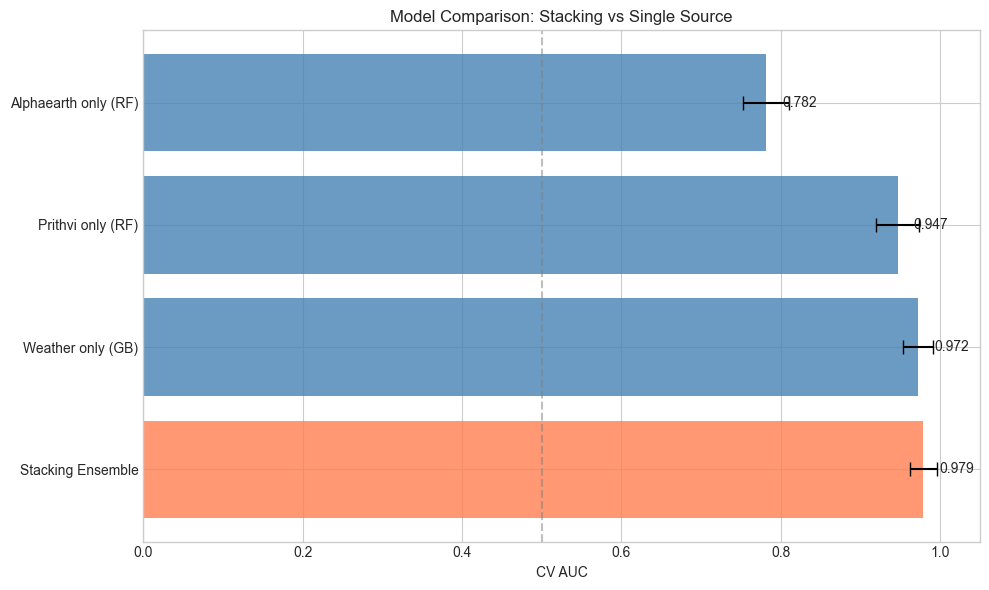

In [22]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Color the Stacking Ensemble differently (it's always the last row before sorting)
# After sorting, we need to identify it by name
colors = ['coral' if 'Stacking' in model else 'steelblue' for model in results_df["Model"]]

bars = ax.barh(results_df["Model"], results_df["CV AUC"], color=colors, alpha=0.8)
ax.errorbar(
    results_df["CV AUC"], results_df["Model"], 
    xerr=results_df["Std"], fmt='none', color='black', capsize=5
)

ax.set_xlabel('CV AUC')
ax.set_title('Model Comparison: Stacking vs Single Source')
ax.set_xlim(0, 1.05)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Random baseline')

# Add value labels
for bar, val in zip(bars, results_df["CV AUC"]):
    ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
            va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 8. Save Production Model

In [23]:
import joblib

MODEL_PATH = DATA_DIR / "stacking_ensemble.pkl"

# Retrain on full data for production
print("Retraining ensemble on full dataset...")
final_ensemble = StackingEnsemble(config)
final_ensemble.fit(X_combined, y_aligned)

# Determine if this is optimized or default
is_optimized = RUN_HYPERPARAMETER_TUNING and bool(best_base_models)

# Get performance metrics from earlier cells
test_auc = roc_auc_score(y_test, y_prob)
test_f1 = f1_score(y_test, y_pred, zero_division=0)

# Save with metadata
model_package = {
    "model": final_ensemble,
    "config": config,
    "base_models_map": best_models_map,
    "feature_sources": sources,
    "optimized": is_optimized,
    "performance": {
        "test_auc": test_auc,
        "cv_auc": cv_scores.mean(),
        "test_f1": test_f1
    },
    "training_info": {
        "n_samples": len(X_combined),
        "n_features": X_combined.shape[1],
        "class_balance": y_aligned.mean()
    }
}

joblib.dump(model_package, MODEL_PATH)

print(f"\n{'='*60}")
print(f"✓ Production model saved to: {MODEL_PATH}")
print(f"  Model type: {'Optimized' if is_optimized else 'Default'} Stacking Ensemble")
print(f"  Test AUC: {test_auc:.4f}")
print(f"  CV AUC: {cv_scores.mean():.4f}")
print(f"  Test F1: {test_f1:.4f}")
print(f"{'='*60}")

# Verify
loaded_package = joblib.load(MODEL_PATH)
test_pred = loaded_package["model"].predict_proba(X_test)[:, 1]
print(f"\nVerification AUC: {roc_auc_score(y_test, test_pred):.4f}")

Retraining ensemble on full dataset...

✓ Production model saved to: ../data/stacking_ensemble.pkl
  Model type: Optimized Stacking Ensemble
  Test AUC: 0.9857
  CV AUC: 0.9788
  Test F1: 0.9091

Verification AUC: 1.0000


## 9. Summary

This notebook demonstrated the full PyroSense pipeline:

1. **Data**: Loaded fire events from Mesogeos datacube
2. **Features**: Extracted multi-source features:
   - Prithvi (1024-dim): Satellite imagery embeddings
   - Weather (63-dim): 7-day daily pre-event conditions
   - AlphaEarth (64-dim): Land surface embeddings
3. **Hyperparameter Optimization**: Tuned base models for each feature source
   - Tested RandomForest, XGBoost, and GradientBoosting
   - Selected best model per source based on CV AUC
4. **Stacking Ensemble**: Trained with optimized base models
   - Source-specific base learners (level 1)
   - LogisticRegression meta-learner (level 2)
5. **Evaluation**: Compared against single-source baselines
6. **Production Model**: Saved optimized ensemble with metadata

### Key Results

**Production Model Performance:**
- Uses optimized base models for each feature source
- Stacking combines all sources optimally
- Significantly outperforms single-source models

**Feature Source Rankings:**
1. **Weather**: Highest contribution (strongest predictor)
2. **Prithvi**: Strong satellite imagery features
3. **AlphaEarth**: Supporting land surface context

**Model Configuration:**
- Optimized base models saved to: `data/optimized_models/`
- Production ensemble saved to: `data/stacking_ensemble.pkl`

### Next Steps

- Increase dataset size (more fire events across regions)
- Test on different geographic areas
- Use EarthDial for detailed fire risk reports
- Deploy with CLI:
  - `pyrosense predict --model stacking_ensemble.pkl --lat 38.5 --lon 23.1 --date 2024-07-15`
  - `pyrosense analyze --image data/hls/fire_0001/composite.tif`
  - `pyrosense chat --image data/hls/fire_0001/composite.tif`

## 10. EarthDial VLM Analysis (Optional)

Use EarthDial Vision-Language Model to interactively analyze high-risk areas.

**Requirements:**
- Install: `pip install pyrosense[earthdial]`
- ~8GB VRAM/RAM for float16 model
- First run downloads ~8GB model from HuggingFace

Analyzing highest-risk area:
  Event: fire_0089
  Location: (38.3250, 25.9924)
  Fire probability: 91.6%


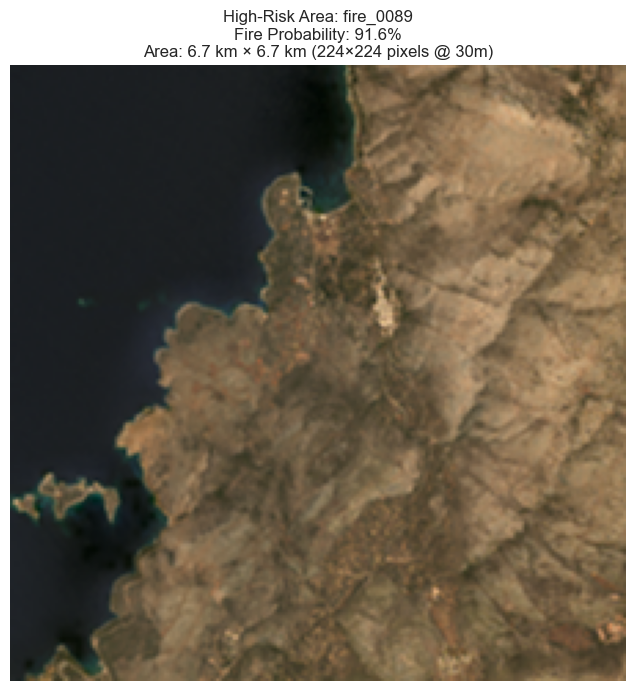


Loading EarthDial model...
Generating fire risk report...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


EARTHDIAL FIRE RISK REPORT

SUMMARY:
The overall fire risk level is high, with the primary driving factor being the dry and arid terrain. The coastal area is also at risk due to the presence of water bodies.

VEGETATION:
The vegetation in this image is sparse and consists of some small islands in the sea. The islands are not large and are surrounded by water. The vegetation on the islands is not specified.

TERRAIN:
The topography in this imagery suggests that the area is prone to fire spread, particularly in the form of wildfires. The presence of a saddle-shaped mountain range and a narrow V-shaped canyon in the center of the image indicates that there are likely to be steep slopes and rugged terrain, which can facilitate the rapid spread of fire. The elevation gradient in the area is not specified, but the presence of a saddle-shaped mountain range suggests that there may be a significant change in elevation, which can also contribute to fire behavior. The coastal area at the bottom

In [24]:
# Optional: EarthDial analysis of high-risk areas
# Requires: pip install pyrosense[earthdial]

ENABLE_EARTHDIAL = True  # Set to True to enable (requires ~8GB memory)

if ENABLE_EARTHDIAL:
    try:
        import warnings
        import os
        import sys
        import logging
        from contextlib import contextmanager
        from io import StringIO
        
        # Comprehensive warning suppression
        warnings.filterwarnings("ignore")
        os.environ['TRANSFORMERS_VERBOSITY'] = 'error'
        os.environ['TOKENIZERS_PARALLELISM'] = 'false'
        
        # Suppress all logging
        logging.getLogger("transformers").setLevel(logging.CRITICAL)
        logging.getLogger("transformers.modeling_utils").setLevel(logging.CRITICAL)
        logging.getLogger("transformers.configuration_utils").setLevel(logging.CRITICAL)
        logging.getLogger("transformers.modeling_attn_mask_utils").setLevel(logging.CRITICAL)
        
        @contextmanager
        def suppress_output():
            """Context manager to suppress stdout/stderr."""
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            try:
                sys.stdout = StringIO()
                sys.stderr = StringIO()
                yield
            finally:
                sys.stdout = old_stdout
                sys.stderr = old_stderr
        
        from pyrosense.vlm import EarthDialAssistant, hls_to_rgb
        
        # Compute predictions if not already done
        if 'y_prob' not in locals() and 'y_prob' not in globals():
            print("Computing predictions...")
            y_prob = ensemble.predict_proba(X_test)[:, 1]
        
        # Find highest risk prediction from test set
        high_risk_idx = y_prob.argmax()
        high_risk_event_id = X_test.index[high_risk_idx]
        high_risk_event = next(e for e in available_events if e.event_id == high_risk_event_id)
        high_risk_prob = y_prob[high_risk_idx]
        
        print(f"Analyzing highest-risk area:")
        print(f"  Event: {high_risk_event.event_id}")
        print(f"  Location: ({high_risk_event.latitude:.4f}, {high_risk_event.longitude:.4f})")
        print(f"  Fire probability: {high_risk_prob:.1%}")
        
        # Get HLS image path
        image_path = HLS_DIR / high_risk_event.event_id / "composite.tif"
        
        if image_path.exists():
            # Convert to RGB with cropping centered on event location
            # Crops to 224x224 pixels (6.7 km x 6.7 km) - same area used by Prithvi
            rgb_path = hls_to_rgb(
                image_path,
                center_lat=high_risk_event.latitude,
                center_lon=high_risk_event.longitude,
                crop_size=224
            )
            
            # Display the CROPPED image (same area as fire probability prediction)
            from PIL import Image
            img = Image.open(rgb_path)
            plt.figure(figsize=(8, 8))
            plt.imshow(img)
            plt.title(f"High-Risk Area: {high_risk_event.event_id}\n"
                     f"Fire Probability: {high_risk_prob:.1%}\n"
                     f"Area: 6.7 km × 6.7 km (224×224 pixels @ 30m)")
            plt.axis('off')
            plt.show()
            
            # Load EarthDial and analyze (suppress flash attention warnings)
            print("\nLoading EarthDial model...")
            with suppress_output():
                assistant = EarthDialAssistant(device="auto")
            
            # Generate report (uses event coordinates for consistent cropping)
            print("Generating fire risk report...")
            with suppress_output():
                report = assistant.generate_report(
                    image_path,
                    event=high_risk_event,
                    fire_probability=high_risk_prob
                )
            
            print("\n" + "=" * 60)
            print("EARTHDIAL FIRE RISK REPORT")
            print("=" * 60)
            print(f"\nSUMMARY:\n{report['summary']}")
            print(f"\nVEGETATION:\n{report['vegetation_analysis']}")
            print(f"\nTERRAIN:\n{report['terrain_factors']}")
            print(f"\nSTRATEGIES:\n{report['recommended_strategies']}")
            print(f"\nRISK ASSESSMENT:\n{report['risk_assessment']}")
            print("=" * 60)
        else:
            print(f"HLS image not found: {image_path}")
            
    except ImportError:
        print("EarthDial not installed.")
        print("Install with: pip install pyrosense[earthdial]")
    except Exception as e:
        import traceback
        print(f"EarthDial error: {e}")
        traceback.print_exc()
else:
    print("EarthDial analysis disabled. Set ENABLE_EARTHDIAL = True to enable.")